##  1. KITTI 데이터셋 수집과 구축
다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄이기

```
$ mkdir -p ~/aiffel/semantic_segmentation/data
$ wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
$ unzip data_semantics.zip -d ~/aiffel/semantic_segmentation/data
```

![image.png](GV8im1.png)


## 데이터 로더 만들기 

- 입력값 (224,224) 출력값(224,224) 크기를 갖는 모델을 학습시키기.

- Augmentation 적용하기

```
$ pip install albumentations
```
 - Augmentation 참고
 https://hwiyong.tistory.com/241    
 
 https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac

In [7]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [8]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

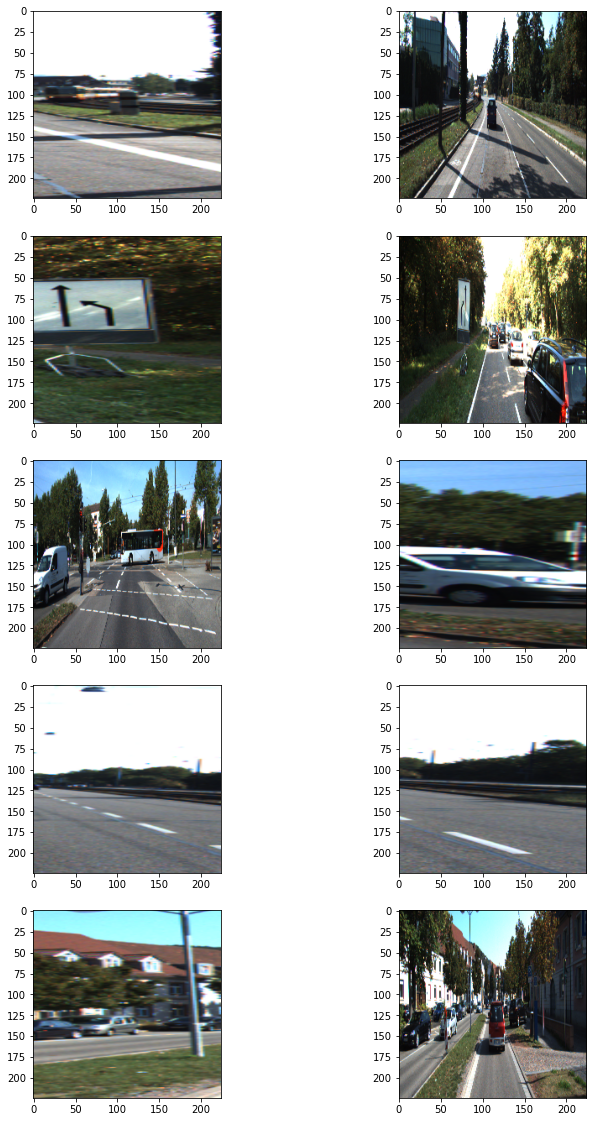

In [9]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [10]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [11]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 2. U-Net++ 모델의 구현
dU-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.

In [ ]:
'''
def build_model(input_shape=(224,224,3),deep_supervision=4)
    model = None
    inputs=input(input_shape)
    first_dim=64
    last=inputs
    
    #Back-bone model
    for i in range(deep_supervision +1)
        globals()['conv_{}_0'.format(i)] = Conv2D(64,3,activation='relu',padding='same',kernel_initializer = 'he_normal')(last)
        globals()['conv_{}_0'.format(i)] = Conv2D(64,3,activation='relu',padding='same',kernel_initializer = 'he_normal')(globals()['conv_{}_0'.format(i)])
        
        if i == deep_supervision -1 : 
            globals()['drop_{}'.format(i)] = Dropout(0.5)(globals()['conv_{}_0'.format(i)])
            globals()['pool_{}_0'.format(i)] = MaxPooling2D(pool_size=(2,2),padding = 'valid')(globals()['drop_{}'.format(i)])
            last = globals()['pool_{}_0'.format(i)]
        
        elif i == deep_supervision:
            globals()['drop_{}'.format(i)] = Dropout(0.5)(globals()['conv_{}_0'.format(i)])
            last = globals()['drop_{}'.format(i)]
        
        else : 
            globals()['pool_{}_0'.format(i)] = MaxPooling2D(pool_size=(2,2),padding = 'valid')(globals()['conv_{}_0'.format(i)])
            last = globals()['pool_{}_0'.format(i)]
  
    
    for i in range(deep_supervision):
    
            
    
    
    
def build_model(input_shape=(224, 224, 3)):
    model = None
   

    
    inputs = input(input_shape)
    conv1 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2),padding = 'valid')(conv1)
    conv2 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer = 'he_normal')(conv2)
    pool2 = Maxpooling2D(pool_size=(2,2),padding = 'valid')(conv2)
    conv3 = Conv2D(256,256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256,256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = Maxpooling2D(pool_size=(2,2),padding = 'valid')(conv3)
    conv4 = Conv2D(512,512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512,512,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv4)
    pool4 = Maxpooling2D(pool_size=(2,2),padding = 'valid')(conv4)
    conv5 = Conv2D(1024,1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024,1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv5)
    
    up6 =  
    
    
    return model
    
'''

In [43]:
def standard_block(input_layer,nb_filter,kernel_size=3):
    x = Conv2D(nb_filter,kernel_size,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    x = Conv2D(nb_filter,kernel_size,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

def UNetPlusPlus(input_shape = (224,224,3)):
    inputs = Input(input_shape)
    conv_1_1 = standard_block(inputs,64)
    pool_1 = MaxPooling2D(pool_size=(2,2))(conv_1_1)
    
    conv_2_1 = standard_block(pool_1,128)
    pool_2 = MaxPooling2D(pool_size=(2,2))(conv_2_1)
    
    up_1_2 = Conv2D(64,3,activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size =(2,2))(conv_2_1))
    conv_1_2 = concatenate([up_1_2,conv_1_1],axis = 3)
    conv_1_2 = standard_block(conv_1_2,64)
    
    conv_3_1 = standard_block(pool_2,256)
    pool_3 = MaxPooling2D(pool_size=(2,2))(conv_3_1)
    
    up_2_2 = Conv2D(128,3,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_3_1))
    conv_2_2 = concatenate([up_2_2,conv_2_1], axis =3)
    conv_2_2 = standard_block(conv_2_2,128)
    
    up_1_3 = Conv2D(64,3,activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_2_2))
    conv_1_3 = concatenate([up_1_3, conv_1_2],axis = 3)
    conv_1_3 = standard_block(conv_1_3,64)
    
    conv_4_1 = standard_block(pool_3,512)
    drop_4 = Dropout(0.5)(conv_4_1)
    pool_4 = MaxPooling2D(pool_size=(2,2))(drop_4)
    
    up_3_2 = Conv2D(256,3,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(drop_4))
    conv_3_2 = concatenate([up_3_2,conv_3_1],axis = 3)
    conv_3_2 = standard_block(conv_3_2,256)
    
    up_2_3 = Conv2D(128,3,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(conv_3_2))
    conv_2_3 = concatenate([up_2_3,conv_2_2],axis = 3)
    conv_2_3 = standard_block(conv_2_3,128)
    
    up_1_4 = Conv2D(64,3,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(conv_2_3))
    conv_1_4 = concatenate([up_1_4, conv_1_3], axis =3)
    conv_1_4 = standard_block(conv_1_4, 64)
    
    conv_5_1 = standard_block(pool_4,1024)
    drop_5 = Dropout(0.5)(conv_5_1)
    
    up_4_2 = Conv2D(512,3,activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(drop_5))
    conv_4_2 = concatenate([up_4_2, drop_4],axis = 3)
    conv_4_2 = standard_block(conv_4_2,512)
    
    up_3_3 = Conv2D(256,3,activation = 'relu', padding='same',kernel_initializer ='he_normal')(UpSampling2D(size=(2,2))(conv_4_2))
    conv_3_3 = concatenate([up_3_3,conv_3_2],axis =3)
    conv_3_3 = standard_block(conv_3_3,256)
    
    up_2_4 = Conv2D(128,3,activation = 'relu', padding='same',kernel_initializer ='he_normal')(UpSampling2D(size=(2,2))(conv_3_3))
    conv_2_4 = concatenate([up_2_4,conv_2_3],axis =3)
    conv_2_4 = standard_block(conv_2_4,128)
    
    up_1_5 = Conv2D(64,3,activation = 'relu', padding='same',kernel_initializer ='he_normal')(UpSampling2D(size=(2,2))(conv_2_4))
    conv_1_5 = concatenate([up_1_5,conv_1_4],axis =3)
    conv_1_5 = standard_block(conv_1_5,64)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv_1_5)
    
    model = Model(inputs = inputs, outputs =outputs)
    return model

## 모델 학습하기

In [44]:
model = UNetPlusPlus()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet_plusplus.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Tensor("dropout_22/cond/Identity:0", shape=(None, 14, 14, 1024), dtype=float32)
up_4_2= Tensor("conv2d_453/Relu:0", shape=(None, 28, 28, 512), dtype=float32)
up_3_3= Tensor("conv2d_456/Relu:0", shape=(None, 56, 56, 256), dtype=float32)
up_2_4= Tensor("conv2d_459/Relu:0", shape=(None, 112, 112, 128), dtype=float32)
conv_2_3 Tensor("conv2d_447/Relu:0", shape=(None, 112, 112, 128), dtype=float32)
conv_2_4= Tensor("conv2d_461/Relu:0", shape=(None, 112, 112, 128), dtype=float32)
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
43/43 [==============================] - 16s 375ms/step - loss: 0.4051 - val_loss: 0.1161
Epoch 2/100
43/43 [==============================] - 16s 375ms/step - loss: 0.0885 - val_loss: 0.0730
Epoch 3/100
43/43 [==============================] - 17s 392ms/step - loss: 0.0804 - val_loss: 0.0795
Epoch 4/100
43/43 [==============================] - 16s 376ms/step - loss: 0.0609 - val_loss: 0.0655
Epoch 5/100
43/43 [==================

43/43 [==============================] - 17s 399ms/step - loss: 0.0389 - val_loss: 0.0576
Epoch 74/100
43/43 [==============================] - 17s 385ms/step - loss: 0.0327 - val_loss: 0.0421
Epoch 75/100
43/43 [==============================] - 18s 429ms/step - loss: 0.0393 - val_loss: 0.0429
Epoch 76/100
43/43 [==============================] - 18s 422ms/step - loss: 0.0373 - val_loss: 0.0394
Epoch 77/100
43/43 [==============================] - 21s 479ms/step - loss: 0.0338 - val_loss: 0.0603
Epoch 78/100
43/43 [==============================] - 17s 393ms/step - loss: 0.0356 - val_loss: 0.0539
Epoch 79/100
43/43 [==============================] - 17s 401ms/step - loss: 0.0314 - val_loss: 0.0505
Epoch 80/100
43/43 [==============================] - 17s 402ms/step - loss: 0.0327 - val_loss: 0.0659
Epoch 81/100
43/43 [==============================] - 17s 407ms/step - loss: 0.0334 - val_loss: 0.0425
Epoch 82/100
43/43 [==============================] - 17s 394ms/step - loss: 0.0291 - 

## 시맨틱 세그멘테이션 모델 시각화
- 오버레이를 통한 시각화. PIL 패키지의 image.blend 활용

- 모델 불러올 때
```
model = tf.keras.models.load_model(model_path)
```


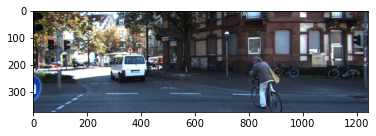

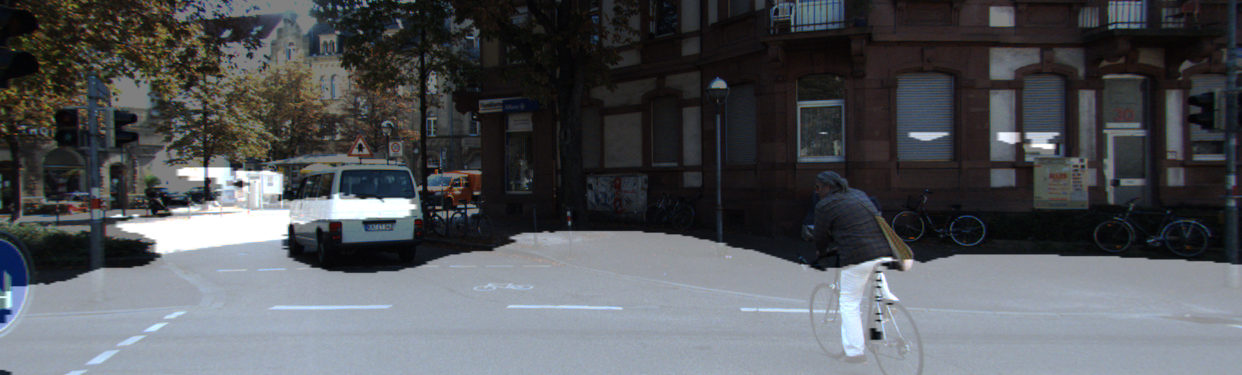

In [52]:
def get_output(model, preproc, image_path, output_path):
    # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.
     origin_img = imread(image_path)
     plt.imshow(origin_img)
     plt.show()
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     
     output.show()
     return output    
    
    
    
model_path_unet = dir_path + '/seg_model_unet.h5'
model_unet = tf.keras.models.load_model(model_path_unet)

model_path_unet_plusplus = dir_path + '/seg_model_unet_plusplus.h5'
model_unet_plusplus = tf.keras.models.load_model(model_path_unet_plusplus)


# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )


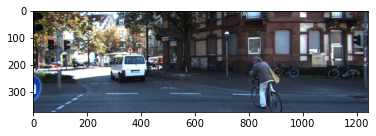

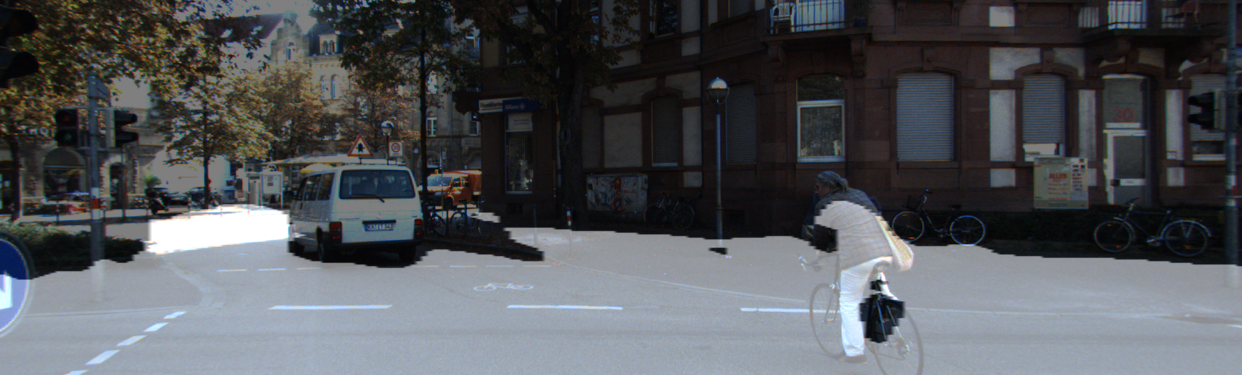

In [53]:
get_output(
     model_unet_plusplus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

## 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하

## IoU 계산하여 성능 추적
 - Intersection over Union 

In [54]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [55]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### i = 8

In [56]:
# Unet 
i = 8    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.774771


0.7747708739265353

In [57]:
# Unet Plus
i = 8    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet_plusplus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.863158


0.8631578947368421

### i = 20

In [58]:
# Unet 
i = 20    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.743262


0.7432617066202957

In [59]:
# Unet Plus
i = 20    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet_plusplus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.793160


0.7931600201918223

### i = 40

In [60]:
# Unet 
i = 40    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.836651


0.836650868878357

In [61]:
# Unet Plus
i = 40    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet_plusplus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.882800


0.8828001267025657

### i =100

In [62]:
# Unet 
i = 100    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.777934


0.7779342027267339

In [63]:
# Unet Plus
i = 100    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet_plusplus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.891142


0.8911418633908088

# 결과

- Unet과 Unet ++ 결과를 육안으로 확인하고 비교해본 결과, Unet ++ 가 디테일한 부분의 Segmentation을 더 정확하게 한 것을 알 수 있다.

- IoU 비교 결과, Unet ++가 약 5%~20% 정도의 성능이 증가된 것을 확인할 수 있다.